In [1]:
import datetime
import time
import unittest
import pandas as pd
import pytz
import matplotlib.pyplot as plt

/tmp/ipykernel_5168/2295897713.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from tigeropen.common.consts import BarPeriod
from tigeropen.quote.quote_client import QuoteClient
from tigeropen.tiger_open_config import TigerOpenClientConfig

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [4]:
def get_client_config():
    """
    https://quant.itigerup.com/#developer 开发者信息获取
    """
    # 港股牌照需用 props_path 参数指定token路径，如 '/Users/xxx/xxx/', 如不指定则取当前路径
    client_config = TigerOpenClientConfig(props_path='tiger_openapi_config.properties')
    return client_config

In [5]:
# 调用上方定义的函数生成用户配置ClientConfig对象
client_config = get_client_config()

# 随后传入配置参数对象来初始化QuoteClient
quote_client = QuoteClient(client_config)

SYMBOL = "symbol"
TIME = "time"
CLOSE = "close"
DATE = "date"

# 需要请求的k线bar的总个数.  total number of requested bars.
BARS_TOTAL_NUMBER = 2000

# 每次请求bar的个数，系统限制每个symbol每次最多请求1200个bar.
# number of bars per request, the system limits each symbol to a maximum of 1200 bars per request.
BARS_BATCH_SIZE = 300

# 每次请求symbol的个数，系统限制每次最多请求50个symbol
# number of symbols per request, the system limits each request to a maximum of 50 symbols.
SYMBOLS_BATCH_SIZE = 50

# 每次请求的间隔时间，防止过快的请求频率触发系统限流. 单位：秒
# The interval between each request, to prevent requests too fast to trigger the system rate limit. Time unit: second
REQUEST_INTERVAL = 0.5

In [6]:
def request_bars(symbols, period, end_time, bars_batch_size):
        """
        请求k线. Request history bars.
        :param symbols: like ['AAPL', 'TSLA']
        :param period: k线周期. tigeropen.common.consts.BarPeriod. like BarPeriod.DAY
        :param end_time: end time in timestamp format. like 1645499400000
        :param bars_batch_size: 每个symbol限制请求的bar数量. bars limit size of each symbol
        :return:
        """
        symbols = list(symbols)
        result = pd.DataFrame()
        for i in range(0, len(symbols), SYMBOLS_BATCH_SIZE):
            part = symbols[i:i + SYMBOLS_BATCH_SIZE]
            quote = quote_client.get_bars(part, period=period, end_time=end_time, limit=bars_batch_size)
            #result = result.append(quote)
            result = pd.concat([result, quote])
            # to avoid rate limit
            time.sleep(REQUEST_INTERVAL)
        return result

In [7]:
# US market
symbols = ['BABA', 'PDD', 'JD', 'NTES', 'NIO', 'XPEV', 'LI']
timezone = 'US/Eastern'

end = int(datetime.datetime.today().timestamp() * 1000)
history = pd.DataFrame()
for i in range(0, BARS_TOTAL_NUMBER, BARS_BATCH_SIZE):
    if i + BARS_BATCH_SIZE <= BARS_TOTAL_NUMBER:
        limit = BARS_BATCH_SIZE
    else:
        limit = i + BARS_BATCH_SIZE - BARS_TOTAL_NUMBER
    end_time = datetime.datetime.fromtimestamp(end/1000, pytz.timezone(timezone))
    print(f'query {len(symbols)} symobls history, end_time:{end} -- {end_time}, limit:{limit}')
    # 其他周期可修改period参数. 
    part = request_bars(symbols=symbols, period=BarPeriod.MONTH, end_time=end, bars_batch_size=BARS_BATCH_SIZE)
    part[DATE] = pd.to_datetime(part[TIME], unit='ms').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if (len(part[TIME]) == 0): 
        break
    end = min(part[TIME])
    history = pd.concat([history, part])
history.set_index([DATE], inplace=True)
history.sort_index(inplace=True)

# 2014年9月1日
history.drop(history[history[TIME] < 1409500800000].index, inplace=True)

history.drop('time', axis=1, inplace=True)
history.drop('amount', axis=1, inplace=True)
history.drop('next_page_token', axis=1, inplace=True)

print(history)

query 7 symobls history, end_time:1707032884200 -- 2024-02-04 02:48:04.200000-05:00, limit:300
query 7 symobls history, end_time:959832000000 -- 2000-06-01 00:00:00-04:00, limit:300
                          symbol     open     high      low    close     volume
date                                                                           
2014-09-01 00:00:00-04:00   NTES   17.544   18.140   16.774   17.132   24260500
2014-09-01 00:00:00-04:00     JD   32.000   32.350   25.300   25.820  108197700
2014-09-01 00:00:00-04:00   BABA   92.700   99.700   86.620   88.850  454681100
2014-10-01 00:00:00-04:00   NTES   17.212   19.158   16.284   18.944   51385500
2014-10-01 00:00:00-04:00   BABA   88.700  100.670   82.810   98.600  399677000
...                          ...      ...      ...      ...      ...        ...
2024-02-01 00:00:00-05:00    NIO    5.730    5.915    5.430    5.540  108346952
2024-02-01 00:00:00-05:00   NTES  100.290  101.760   98.185   98.830    2459591
2024-02-01 00:00:0

In [8]:
ind = history.groupby('date').agg({'open':'sum', 'high':'sum', 'low':'sum', 'close':'sum', 'volume':'sum'}).reset_index()
indexation = pd.DataFrame(ind)
indexation.set_index([DATE], inplace=True)
indexation.sort_index(inplace=True)

print(indexation)

                              open      high      low    close      volume
date                                                                      
2014-09-01 00:00:00-04:00  142.244  150.1900  128.694  131.802   587139300
2014-10-01 00:00:00-04:00  131.432  146.6180  121.694  141.434   546810500
2014-11-01 00:00:00-04:00  142.368  169.8940  140.676  156.294   803599100
2014-12-01 00:00:00-05:00  154.490  158.8200  142.026  146.908   512507200
2015-01-01 00:00:00-05:00  147.574  154.5880  129.690  135.770   502175600
...                            ...       ...      ...      ...         ...
2023-10-01 00:00:00-04:00  377.268  406.2363  348.760  371.890  1784067732
2023-11-01 00:00:00-04:00  372.155  453.2400  359.580  424.060  2078303678
2023-12-01 00:00:00-05:00  416.430  435.3050  365.560  406.960  2835371119
2024-01-01 00:00:00-05:00  398.980  420.9700  336.870  360.860  2890076288
2024-02-01 00:00:00-05:00  365.955  371.3373  354.725  359.120   231815612

[114 rows x 5 columns]


In [9]:
import cufflinks as cf

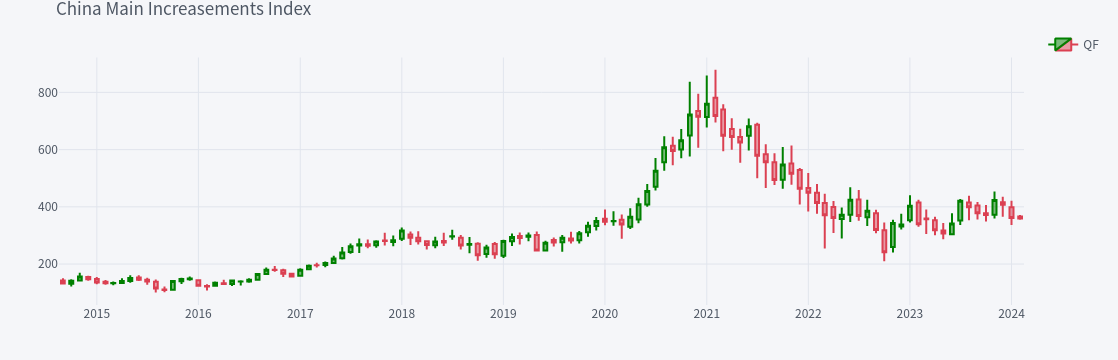

In [10]:
cf.set_config_file(offline=True, world_readable=True)
qf = cf.QuantFig(indexation, title="China Main Increasements Index", legend="right", name="QF")
#qf.add_volume()
# qf.add_trendline('2014-09-01','2024-01-01',on='close',textangle=0)
qf.iplot(up_color='green',down_color='red')

In [11]:
cnn = indexation
# 价格动量
cnn['6m_MA'] = cnn[CLOSE].rolling(window=6).mean()
cnn.dropna(how='any', inplace=True)
cnn['Momentum'] = cnn[CLOSE] / cnn['6m_MA']
print(cnn)

                              open      high      low    close      volume       6m_MA  Momentum
date                                                                                            
2015-02-01 00:00:00-05:00  138.028  144.0640  127.998  132.798   372558500  140.834333  0.942938
2015-03-01 00:00:00-05:00  133.080  139.1080  125.914  133.680   588310200  141.147333  0.947095
2015-04-01 00:00:00-04:00  133.766  150.0880  130.386  140.488   517827500  140.989667  0.996442
2015-05-01 00:00:00-04:00  140.580  160.4900  134.272  151.282   615739500  140.154333  1.079396
2015-06-01 00:00:00-04:00  152.708  160.5760  140.592  145.344   481247700  139.893667  1.038961
...                            ...       ...      ...      ...         ...         ...       ...
2023-10-01 00:00:00-04:00  377.268  406.2363  348.760  371.890  1784067732  369.481667  1.006518
2023-11-01 00:00:00-04:00  372.155  453.2400  359.580  424.060  2078303678  388.990000  1.090157
2023-12-01 00:00:00-05:00  416

In [12]:
# 价格强度
cnn['12m_High'] = cnn[CLOSE].rolling(window=12).max()
cnn['12m_Low'] = cnn[CLOSE].rolling(window=12).min()
cnn.dropna(how='any', inplace=True)
new_highs = (cnn[CLOSE] == cnn['12m_High']).sum()
new_lows = (cnn[CLOSE] == cnn['12m_Low']).sum()
cnn['Strength'] = new_highs / (new_highs + new_lows)

print(cnn)

                               open      high       low    close      volume       6m_MA  Momentum  12m_High  12m_Low  Strength
date                                                                                                                           
2016-01-01 00:00:00-05:00  143.2700  144.4832  120.4100  124.288   712294371  130.968167  0.948994   151.282  109.054  0.717949
2016-02-01 00:00:00-05:00  123.2900  129.5580  107.3050  121.442   723146559  132.169167  0.918838   151.282  109.054  0.717949
2016-03-01 00:00:00-05:00  124.1280  139.1800  121.5900  134.246   599570853  136.367833  0.984440   151.282  109.054  0.717949
2016-04-01 00:00:00-04:00  132.9640  145.2100  126.3740  130.640   568643333  134.748500  0.969510   151.282  109.054  0.717949
2016-05-01 00:00:00-04:00  130.2880  143.5000  123.4300  142.178   977599422  133.762833  1.062911   149.783  109.054  0.717949
2016-06-01 00:00:00-04:00  138.7020  143.1640  125.0100  139.404   880074920  132.033000  1.055827   149

In [13]:
# 价格宽度
advances = (cnn[CLOSE].diff() > 0).sum()
declines = (cnn[CLOSE].diff() < 0).sum()
cnn['Breadth'] = advances / (advances + declines)
# 市场波动
cnn['Volatility'] = cnn[CLOSE].pct_change().rolling(window=12).std()
# 市场成交量
cnn['Volume_Change'] = cnn['volume'].pct_change()
cnn.dropna(how='any', inplace=True)
print(cnn)

                               open      high       low    close      volume       6m_MA  Momentum  12m_High  12m_Low  Strength   Breadth  Volatility  Volume_Change
date                                                                                                                                                                
2017-01-01 00:00:00-05:00  158.8260  185.0160  156.7910  180.490   489884828  171.097667  1.054895   180.490  121.442  0.717949  0.515464    0.078670       0.061687
2017-02-01 00:00:00-05:00  181.9380  198.0600  177.9282  194.482   407946912  176.012333  1.104934   194.482  130.640  0.717949  0.515464    0.077362      -0.167260
2017-03-01 00:00:00-05:00  196.0140  204.6520  188.0420  195.740   484410167  178.629667  1.095787   195.740  130.640  0.717949  0.515464    0.075311       0.187434
2017-04-01 00:00:00-04:00  196.9480  208.8660  189.1180  203.648   402291859  182.731333  1.114467   203.648  139.404  0.717949  0.515464    0.072796      -0.169522
2017-05-01

In [14]:
# 标准化指标
factors = ['Momentum', 'Strength', 'Breadth', 'Volatility', 'Volume_Change']
indexation_normalized = (cnn[factors] - cnn[factors].min()) / (cnn[factors].max() - cnn[factors].min())

# 计算恐慌贪婪指数
cnn['Fear_Greed_Index'] = indexation_normalized.mean(axis=1) * 100

# 查看恐慌贪婪指数
cnn.dropna(how='any', inplace=True)
print(cnn)

                               open      high       low    close      volume       6m_MA  Momentum  12m_High  12m_Low  Strength   Breadth  Volatility  Volume_Change  Fear_Greed_Index
date                                                                                                                                                                                  
2017-01-01 00:00:00-05:00  158.8260  185.0160  156.7910  180.490   489884828  171.097667  1.054895   180.490  121.442  0.717949  0.515464    0.078670       0.061687         39.019303
2017-02-01 00:00:00-05:00  181.9380  198.0600  177.9282  194.482   407946912  176.012333  1.104934   194.482  130.640  0.717949  0.515464    0.077362      -0.167260         38.243289
2017-03-01 00:00:00-05:00  196.0140  204.6520  188.0420  195.740   484410167  178.629667  1.095787   195.740  130.640  0.717949  0.515464    0.075311       0.187434         41.967650
2017-04-01 00:00:00-04:00  196.9480  208.8660  189.1180  203.648   402291859  182.731

/home/zhangruian/.local/lib/python3.11/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



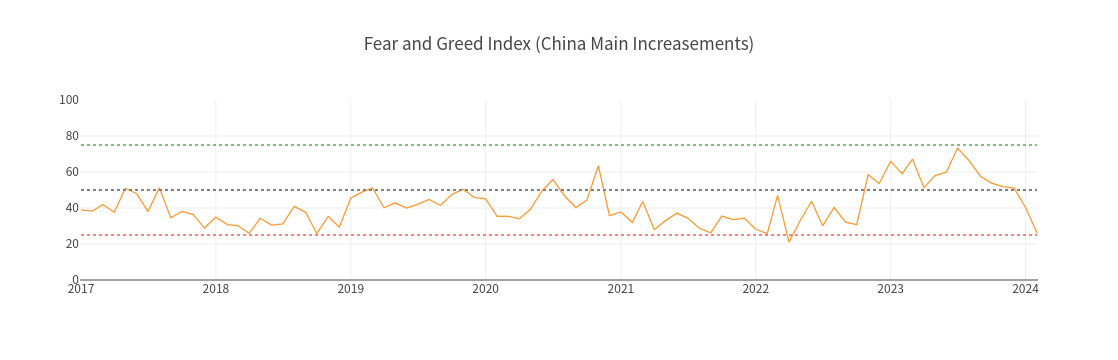

In [15]:
layout = {
    'shapes': [
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 75,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 75,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'green',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 50,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 50,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'gray',
                'width': 2,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 25,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 25,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'red',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        }
    ],
    'yaxis': {
        'range': [0, 100]  # 设置y轴的最小值和最大值
    },
    'y0': 50,  # 指定线的y值
    'title': 'Fear and Greed Index (China Main Increasements)'
}

cnn['Fear_Greed_Index'].iplot(kind='line', layout=layout)